## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Helper Functions

In [143]:
def cal_undistort(img, objpoints, imgpoints):
    """computes the camera calibration matrix and distortion coefficients
    and applies distortion correction to an image"""
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


def color_gradient_thresholding(img, s_thresh=(170, 255), sobel_kernel=3, thresh=(20, 100), thresh_mag=(30,100), thresh_dir=(0, np.pi/2)):
    """applies color and gradient thresholding to image in order to create
    a binary image which likely contains lane-line pixels"""
    
    #calculate x gradient thresholded image
    gradx_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=sobel_kernel, thresh=thresh)
    print("Sobelx, Gradient threshold:")
    plt.imshow(gradx_binary,cmap='gray')
    plt.show()
    
    #calculate y gradient thresholded image
    grady_binary = abs_sobel_thresh(img, orient='y', sobel_kernel=sobel_kernel, thresh=thresh)
    print("Sobely, Gradient threshold:")
    plt.imshow(grady_binary,cmap='gray')
    plt.show()
    
    #calculate gradient magnitude thresholded image
    mag_binary = mag_thresh(img, sobel_kernel=sobel_kernel, thresh_mag=thresh_mag)
    print("Gradient mag threshold:")
    plt.imshow(mag_binary,cmap='gray')
    plt.show()
    
    #calculate gradient diretion thresholded image
    dir_binary = dir_threshold(img, sobel_kernel=sobel_kernel, thresh_dir=thresh_dir)
    print("Gradient dir threshold:")
    plt.imshow(dir_binary,cmap='gray')
    plt.show()
    
    #combining gradient threshold techniques
    combined_grad_binary = np.zeros_like(dir_binary)
    combined_grad_binary[((gradx_binary == 1) & (grady_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    print("Combined grad threshold:")
    plt.imshow(combined_grad_binary,cmap='gray')
    plt.show()
    
    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    print("S channel:")
    plt.imshow(s_channel,cmap='gray')
    plt.show()
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    print("S threshold:")
    plt.imshow(s_binary,cmap='gray')
    plt.show()
    
    # Combine the two binary thresholds (gradient threshold and S channel threshold)
    combined_binary = np.zeros_like(gradx_binary)
    combined_binary[(s_binary == 1) | (combined_grad_binary == 1)] = 1
    
    return combined_binary



def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100)):
    """Compute directional gradient, apply threshold"""
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    print("Grayscale image:")
    plt.imshow(gray,cmap='gray')
    plt.show()
    
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return grad_binary


def mag_thresh(image, sobel_kernel=3, thresh_mag=(30, 100)):
    """Compute gradient magnitude, apply threshold"""
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= thresh_mag[0]) & (gradmag <= thresh_mag[1])] = 1

    # Return the binary image
    return mag_binary


def dir_threshold(image, sobel_kernel=3, thresh_dir=(0.7, 1.3)):
    """Compute gradient direction, apply threshold"""
    
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh_dir[0]) & (absgraddir <= thresh_dir[1])] = 1

    # Return the binary image
    return dir_binary


def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

## First, I'll compute the camera calibration using chessboard images

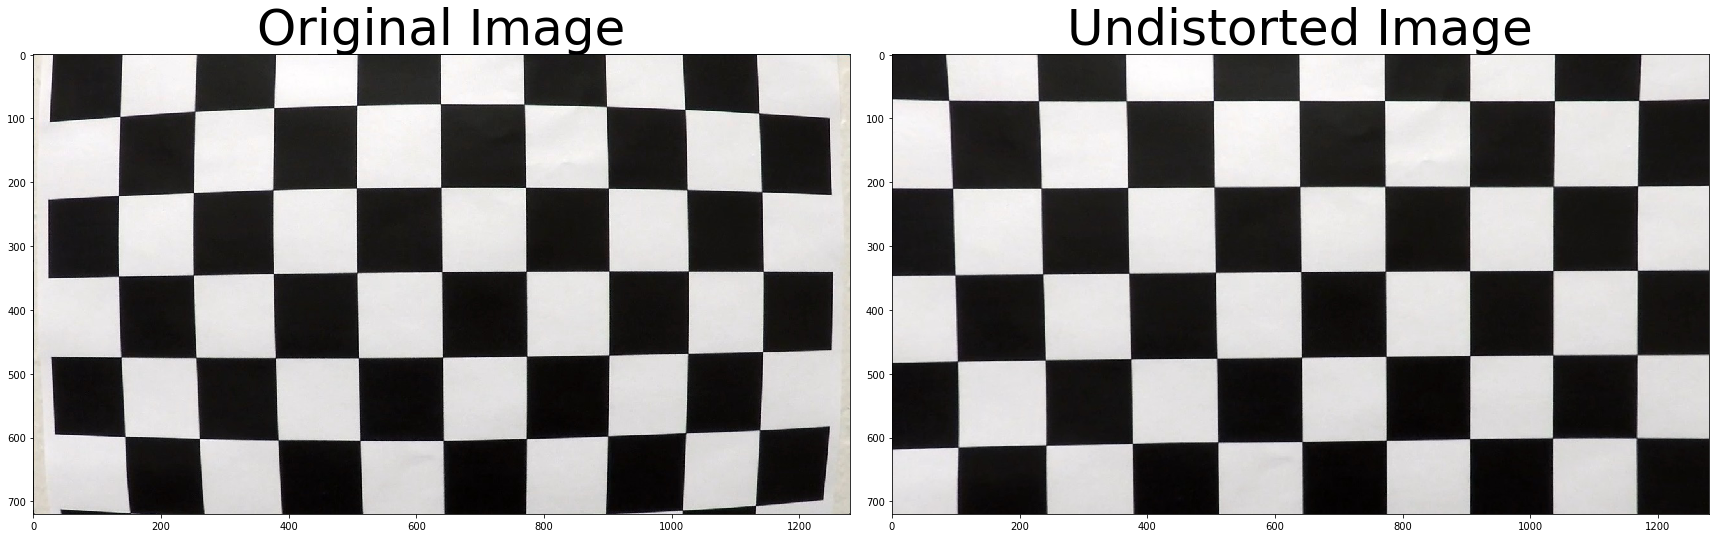

In [68]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os.path
%matplotlib qt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #plt.imshow(img)

        
fpath = "camera_cal/calibration1.jpg"
#extract basename from path fpath
fn = os.path.basename(fpath)

#read in a calibration image
img = mpimg.imread(fpath)
        
#apply camera calibration and distortion correction to calibration image
undistorted = cal_undistort(img, objpoints, imgpoints)

#store original image and undistorted as a figure to folder output_images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
f.savefig("output_images/undistort_output_{}".format(fn))

## Pipeline for lane-line detection based on test images

Grayscale image:


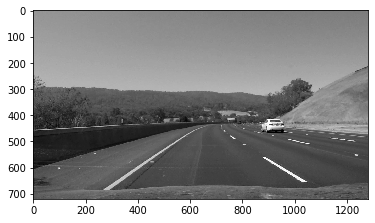

Sobelx, Gradient threshold:


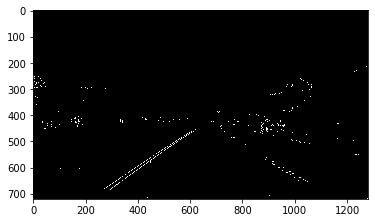

Grayscale image:


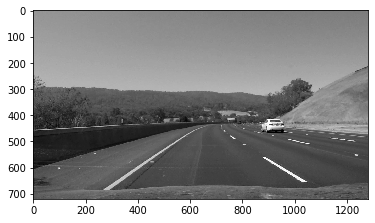

Sobely, Gradient threshold:


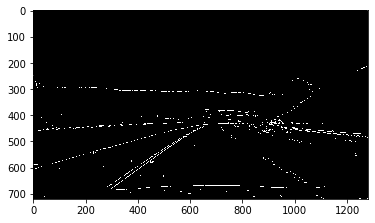

Gradient mag threshold:


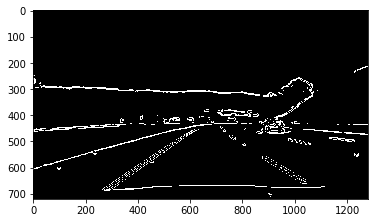

Gradient dir threshold:


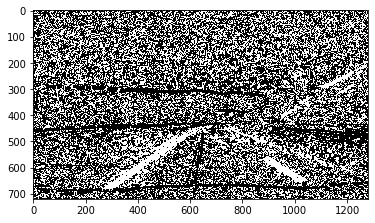

Combined grad threshold:


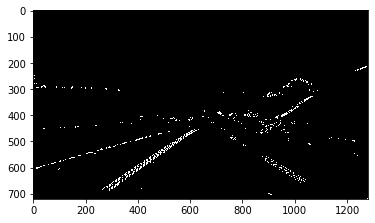

S channel:


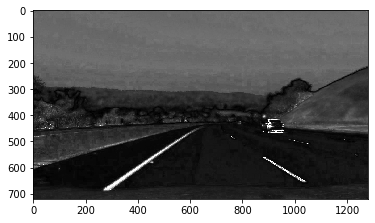

S threshold:


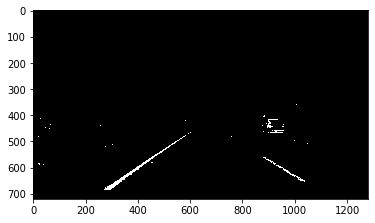

Binary Combo:


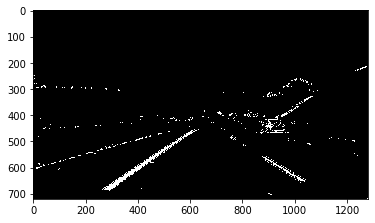

(720, 1280, 3)
Region of interest:


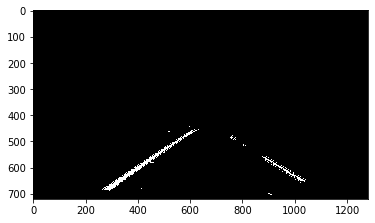

Grayscale image:


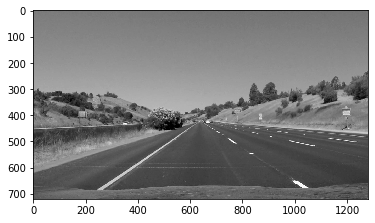

Sobelx, Gradient threshold:


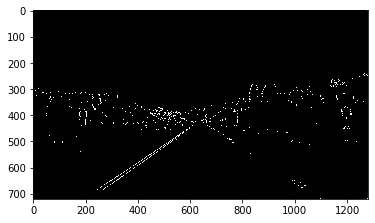

Grayscale image:


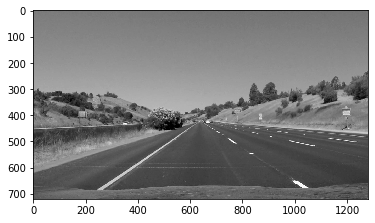

Sobely, Gradient threshold:


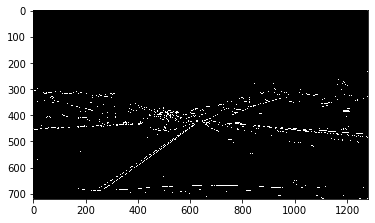

Gradient mag threshold:


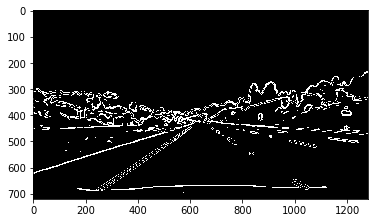

Gradient dir threshold:


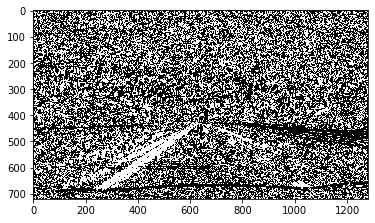

Combined grad threshold:


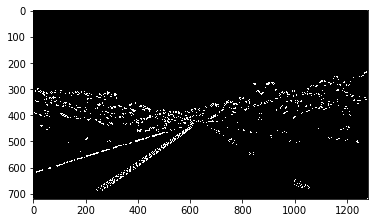

S channel:


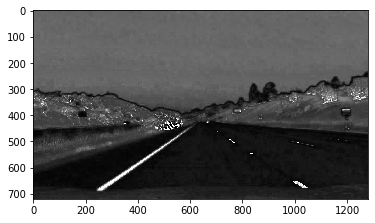

S threshold:


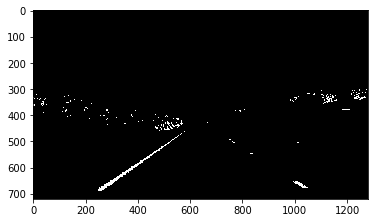

Binary Combo:


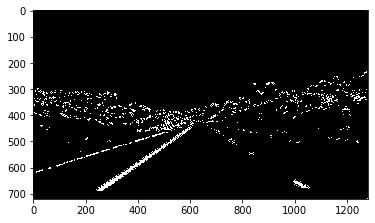

(720, 1280, 3)
Region of interest:


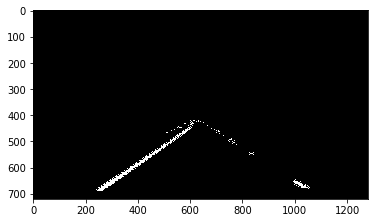

Grayscale image:


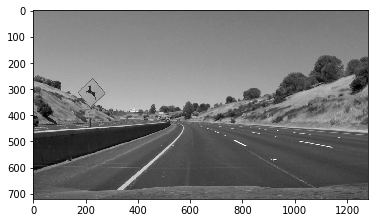

Sobelx, Gradient threshold:


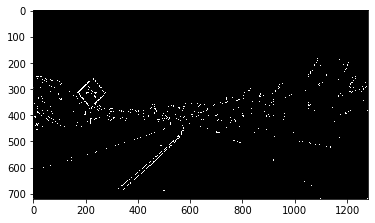

Grayscale image:


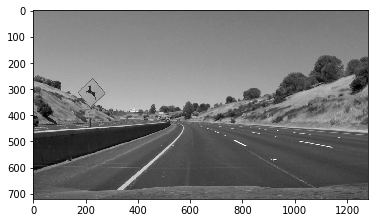

Sobely, Gradient threshold:


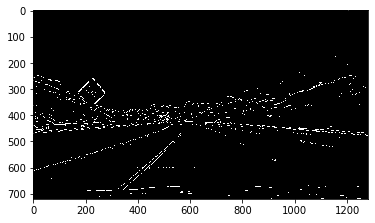

Gradient mag threshold:


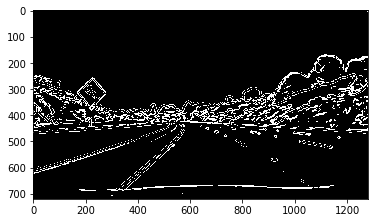

Gradient dir threshold:


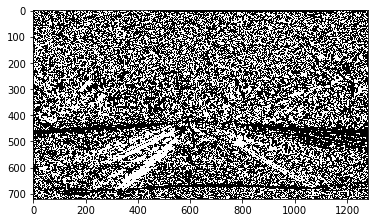

Combined grad threshold:


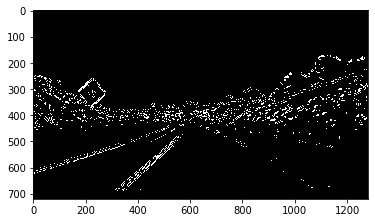

S channel:


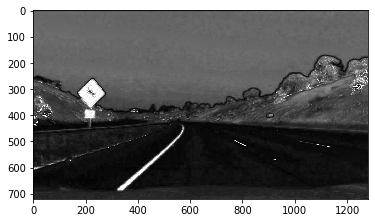

S threshold:


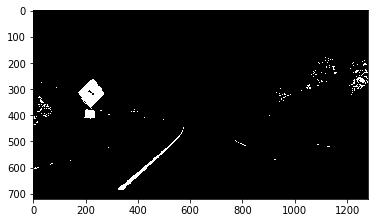

Binary Combo:


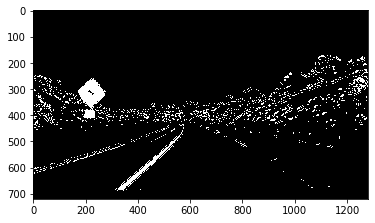

(720, 1280, 3)
Region of interest:


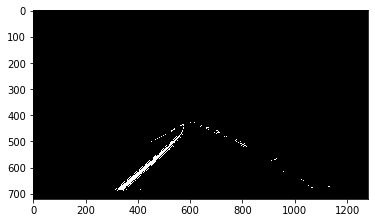

Grayscale image:


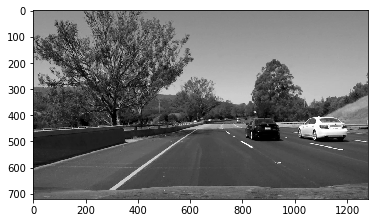

Sobelx, Gradient threshold:


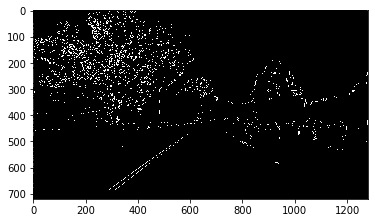

Grayscale image:


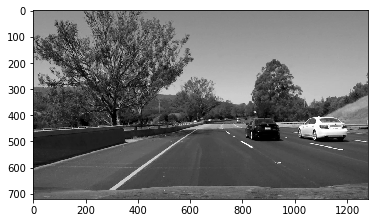

Sobely, Gradient threshold:


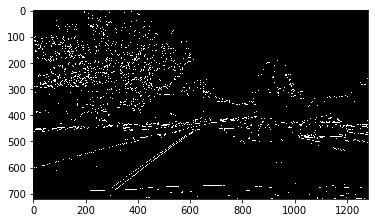

Gradient mag threshold:


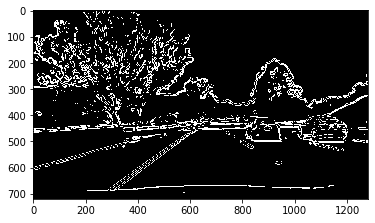

Gradient dir threshold:


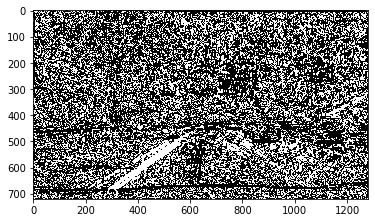

Combined grad threshold:


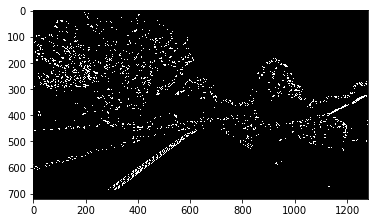

S channel:


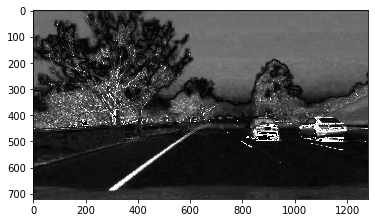

S threshold:


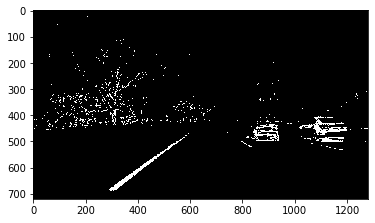

Binary Combo:


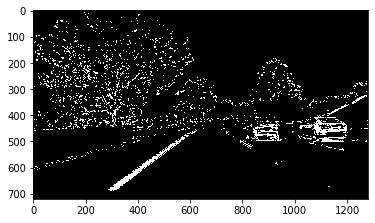

(720, 1280, 3)
Region of interest:


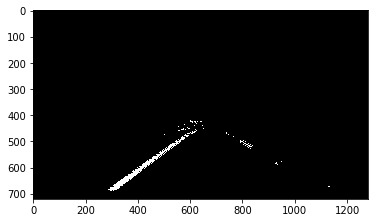

Grayscale image:


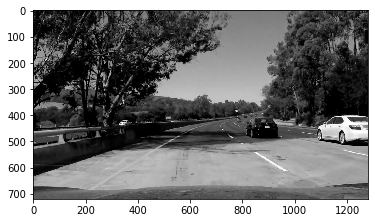

Sobelx, Gradient threshold:


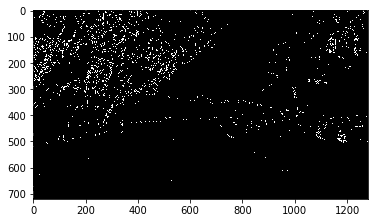

Grayscale image:


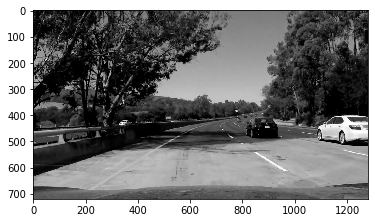

Sobely, Gradient threshold:


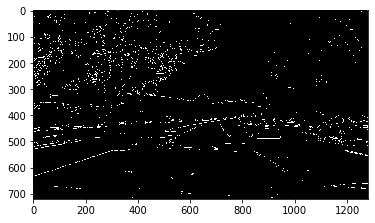

Gradient mag threshold:


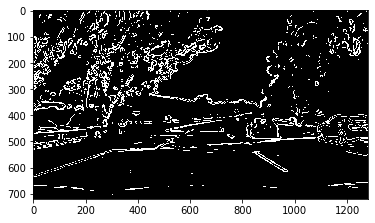

Gradient dir threshold:


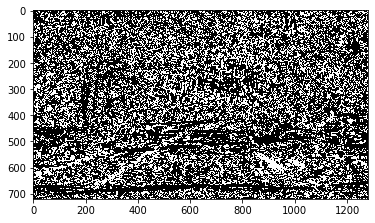

Combined grad threshold:


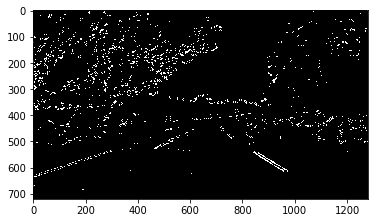

S channel:


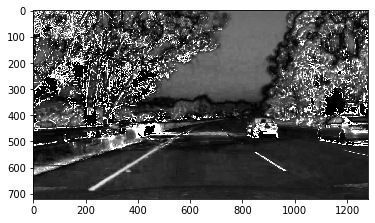

S threshold:


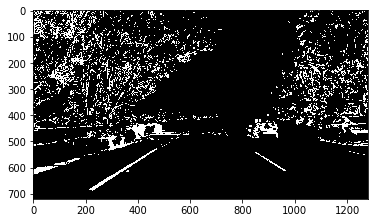

Binary Combo:


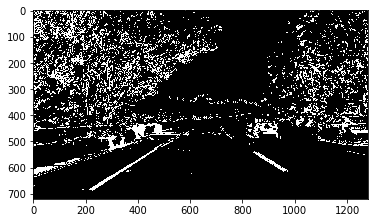

(720, 1280, 3)
Region of interest:


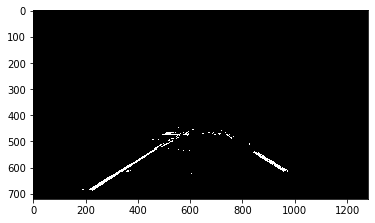

Grayscale image:


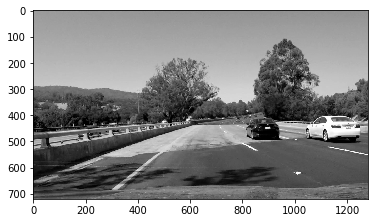

Sobelx, Gradient threshold:


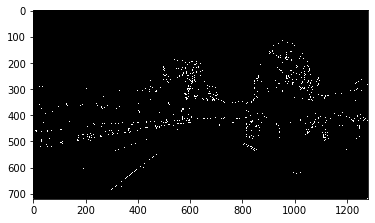

Grayscale image:


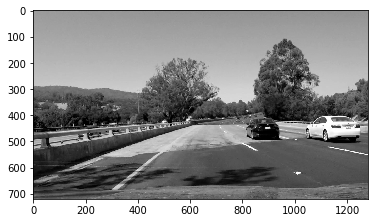

Sobely, Gradient threshold:


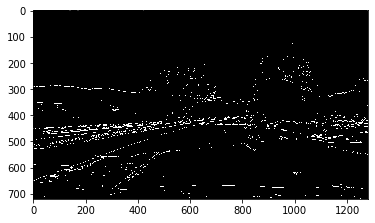

Gradient mag threshold:


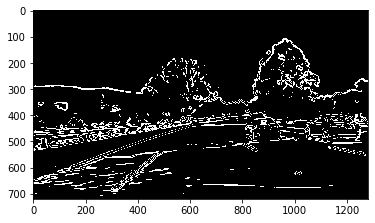

Gradient dir threshold:


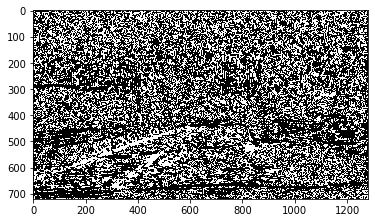

Combined grad threshold:


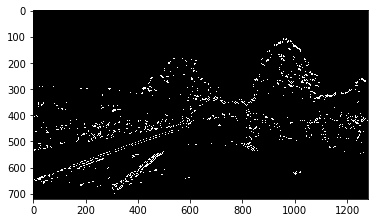

S channel:


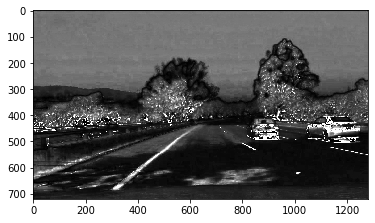

S threshold:


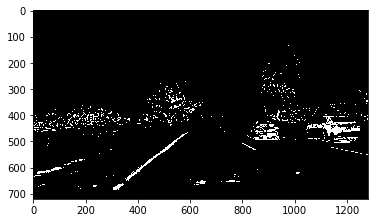

Binary Combo:


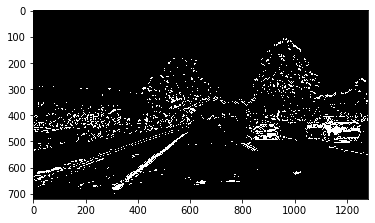

(720, 1280, 3)
Region of interest:


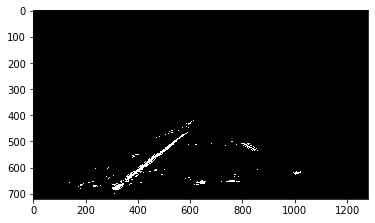

Grayscale image:


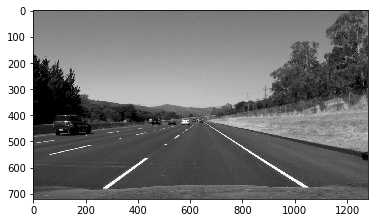

Sobelx, Gradient threshold:


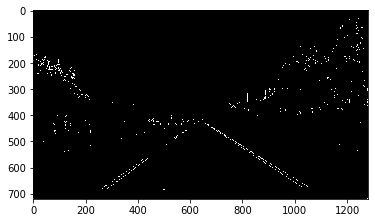

Grayscale image:


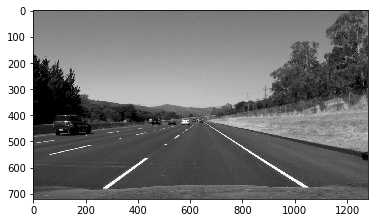

Sobely, Gradient threshold:


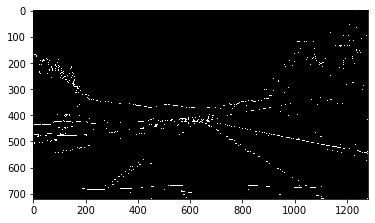

Gradient mag threshold:


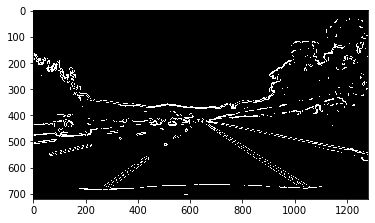

Gradient dir threshold:


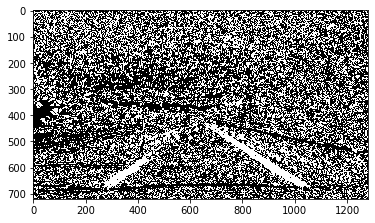

Combined grad threshold:


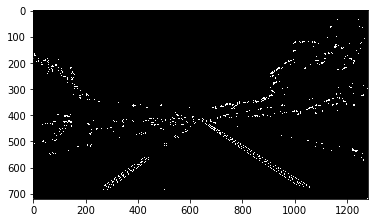

S channel:


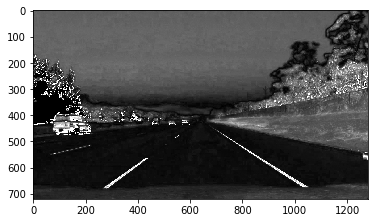

S threshold:


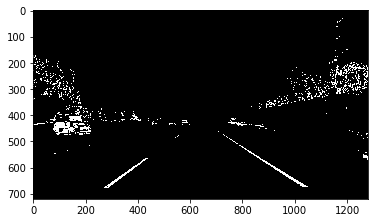

Binary Combo:


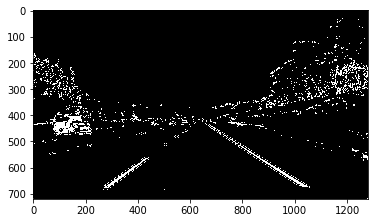

(720, 1280, 3)
Region of interest:


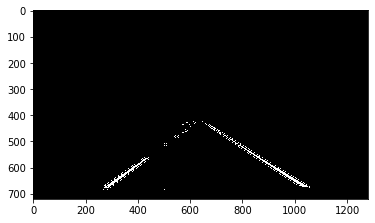

Grayscale image:


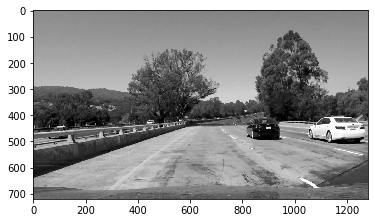

Sobelx, Gradient threshold:


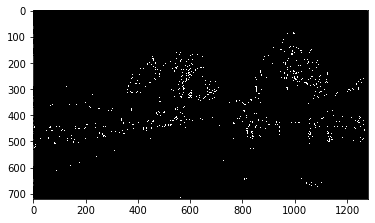

Grayscale image:


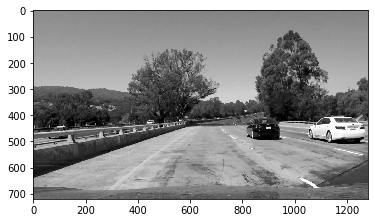

Sobely, Gradient threshold:


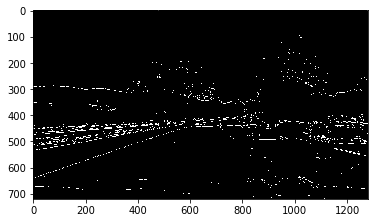

Gradient mag threshold:


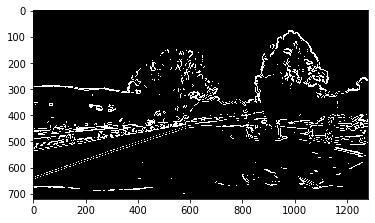

Gradient dir threshold:


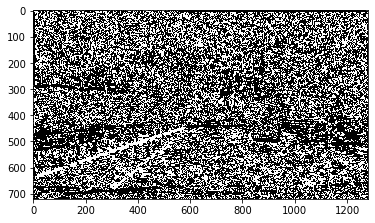

Combined grad threshold:


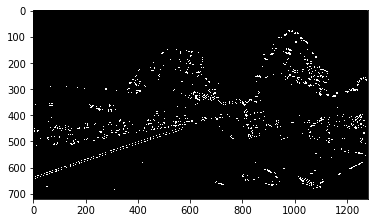

S channel:


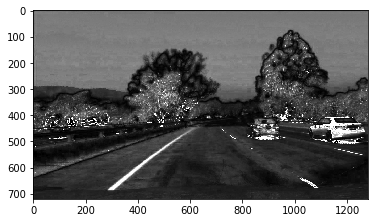

S threshold:


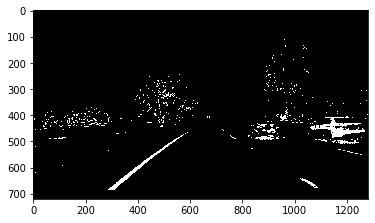

Binary Combo:


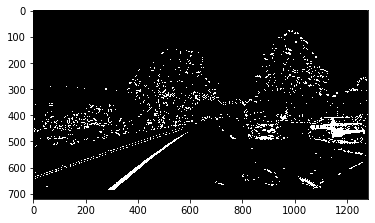

(720, 1280, 3)
Region of interest:


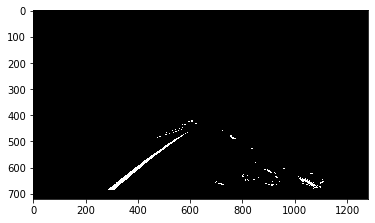

In [150]:
# Make a list of test images
images = glob.glob('test_images/*.jpg')

for fname in images:
    
    img = mpimg.imread(fname)
    
    #extract basename from path fpath
    fn = os.path.basename(fname)
    
    #apply color and gradient thresholding
    binary_combo = color_gradient_thresholding(img, sobel_kernel=29, s_thresh=(150, 255), thresh=(50, 100), thresh_mag=(50,100), thresh_dir=(0.7, 1.3))
    print("Binary Combo:")
    plt.imshow(binary_combo,cmap='gray')
    plt.imsave("output_images/binary_combo_{}".format(fn),binary_combo,cmap='gray')
    plt.show()
    
    #apply region of interest mask to lane lines
    imshape = img.shape
    print(imshape)
    vertices = np.array([[(0,imshape[0]),(600, 420), (640, 420), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_binary_combo = region_of_interest(binary_combo, vertices)
    print("Region of interest:")
    plt.imshow(masked_binary_combo, cmap='gray')
    plt.show()